Data Loaded Successfully
Preprocessing Successful
Data Argumentation was Successful. Time taken for data augmentation: 2.94 sec
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 encoder1 (Functional)          (None, 128)          355520      ['sequential[3][0]']             
                                                                                                  
 encoder2 (Functional)          (None, 128)          691520      

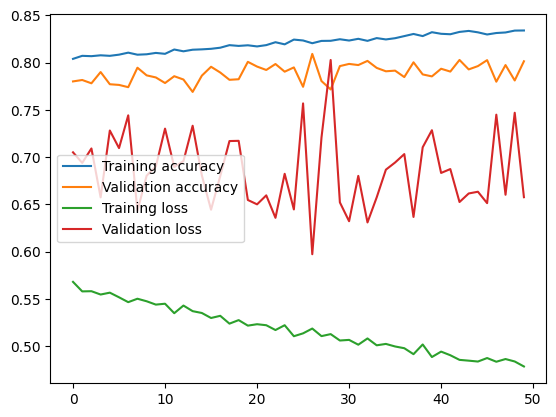

In [2]:
# Code to Include Cofusion matrix - NTP
import time
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Reshape, Conv2DTranspose
from keras.models import Model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Data Loaded Successfully")

#Preprocessing
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print("Preprocessing Successful")

#Data augmentation
start_time = time.time()
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])
end_time = time.time()
print('Data Argumentation was Successful. Time taken for data augmentation: %.2f sec' % (end_time - start_time))

# Define a function to make non-trainable parameters zero
def make_weights_zero(layer):
    layer.trainable = False
    if hasattr(layer, 'bias'):
        layer.bias.assign(tf.zeros_like(layer.bias))

input_shape = (32, 32, 3)
latent_dim = 128


# Encoder 1
inputs1 = Input(shape=input_shape, name='encoder1_input')
x1 = data_augmentation(inputs1)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)
latent1 = Dense(latent_dim, name='latent1')(x1)
encoder1 = Model(inputs1, latent1, name='encoder1')

# Encoder 2
inputs2 = Input(shape=input_shape, name='encoder2_input')
x2 = data_augmentation(inputs2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)
latent2 = Dense(latent_dim, name='latent2')(x2)
encoder2 = Model(inputs2, latent2, name='encoder2')

# Encoder 3
inputs3 = Input(shape=input_shape, name='encoder3_input')
x3 = data_augmentation(inputs3)
x3 = Conv2D(16, (3, 3), activation='relu', padding='same')(x3)
x3 = MaxPooling2D((2, 2))(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = MaxPooling2D((2, 2))(x3)
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
x3 = MaxPooling2D((2, 2))(x3)
x3 = Flatten()(x3)
latent3 = Dense(latent_dim, name='latent3')(x3)
encoder3 = Model(inputs3, latent3, name='encoder3')


#Concatenate outputs of encoder models
latent_concat = Concatenate()([latent1, latent2, latent3])

#Classifier
x = Dropout(0.5)(latent_concat)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

#Model
inputs = Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
latent_concat = Concatenate()([encoder1(x), encoder2(x), encoder3(x)])
x = Dropout(0.5)(latent_concat)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

#Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train model and record training time and accuracies
num_runs = 2
test_accs = np.zeros(num_runs)
train_accs = np.zeros(num_runs)
train_times = np.zeros(num_runs)
for i in range(num_runs):
    start_time = time.time()
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                        steps_per_epoch=len(x_train) // 64,
                        epochs=50,
                        validation_data=(x_test, y_test),
                        verbose=2)
    end_time = time.time()
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
    test_accs[i] = test_acc
    train_accs[i] = train_acc
    train_times[i] = end_time - start_time
    print('Run %d: Test accuracy: %.4f, Training accuracy: %.4f, Training time: %.2f sec' % (i+1, test_acc, train_acc, train_times[i]))

#Print average test accuracy, average training accuracy, and average training time
print('Average test accuracy: %.4f' % np.mean(test_accs))
print('Average training accuracy: %.4f' % np.mean(train_accs))
print('Average training time: %.2f sec' % np.mean(train_times))

#Plot accuracies and loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()
# Confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap='Reds')
plt.colorbar()
plt.title('Confusion matrix')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

313/313 [==============================] - 3s 5ms/step


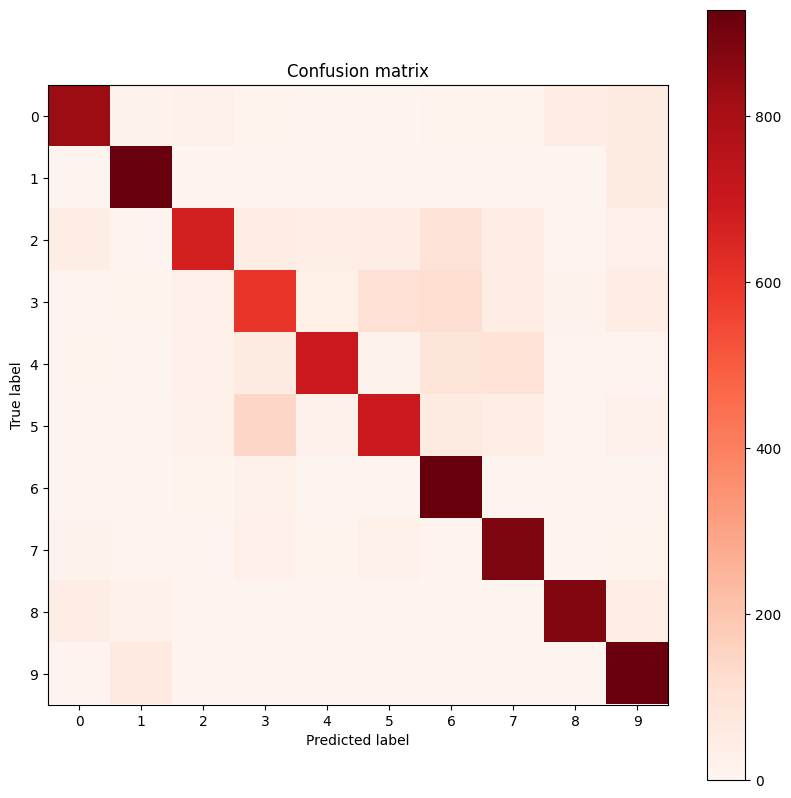

In [3]:
# Confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap='Reds')
plt.colorbar()
plt.title('Confusion matrix')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()